In [5]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from langchain.embeddings import HuggingFaceEmbeddings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix

from langchain.embeddings import HuggingFaceEmbeddings

from transformers import BertTokenizerFast, AutoTokenizer, AutoModel, BertTokenizer, BertForSequenceClassification
from huggingface_hub import HfApi

from lightning import Trainer
import lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import wandb

from copy import copy

import torch
from torch.functional import F
from torch.utils.data import Dataset, DataLoader

from dotenv import load_dotenv

torch.set_float32_matmul_precision('medium')

In [2]:
load_dotenv()

hf_write_token = os.environ["HF_ACCESS_TOKEN_WRITE"]

In [52]:
df_train = pd.read_parquet("../data/train_synthetic.parquet")
df_test = pd.read_parquet("../data/test_synthetic.parquet")

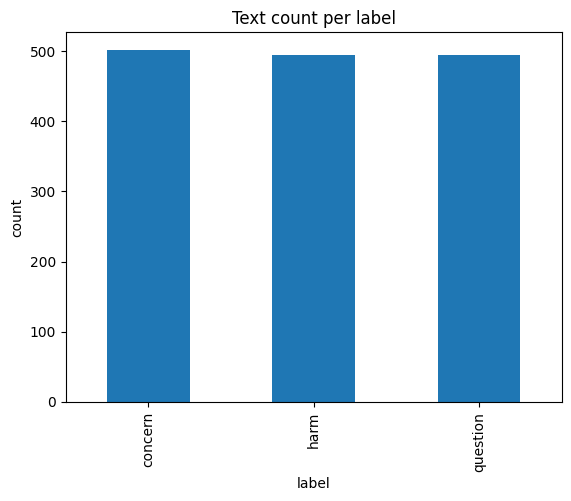

In [53]:
df_train.groupby("label").size().plot.bar()
plt.xlabel("label")
plt.ylabel("count")
plt.title("Text count per label")
plt.show()

In [54]:
print("Duplicates in train df: ", df_train.text.duplicated().sum())
print("Duplicates in test df: ", df_test.text.duplicated().sum())

print("Intersection between train and test: ", len(np.intersect1d(df_train.text.values, df_test.text.values)))
print("Length of train set: ", len(df_train))
print("Length of test set: ", len(df_test))

Duplicates in train df:  0
Duplicates in test df:  0
Intersection between train and test:  0
Length of train set:  1490
Length of test set:  371


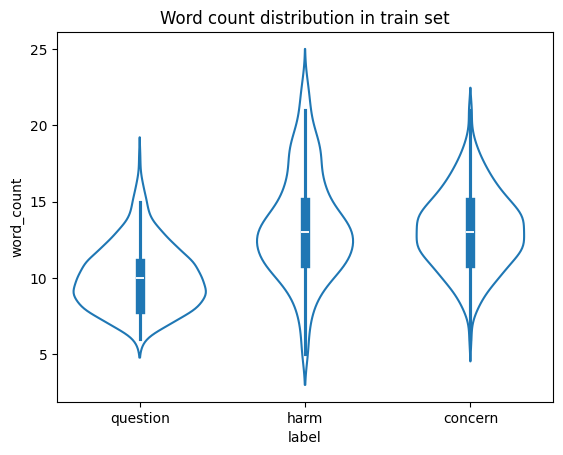

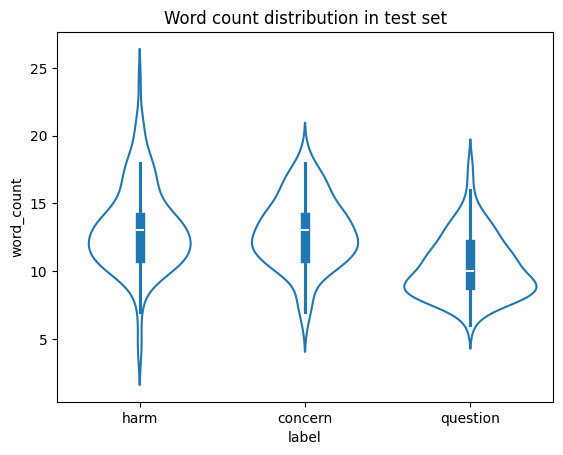

In [55]:
sns.violinplot(df_train.assign(word_count=df_train['text'].apply(lambda x: len(x.split(" "))))[["label", "word_count"]], x="label", y="word_count", fill=False) 
plt.title("Word count distribution in train set")
plt.show()

sns.violinplot(df_test.assign(word_count=df_test['text'].apply(lambda x: len(x.split(" "))))[["label", "word_count"]], x="label", y="word_count", fill=False) 
plt.title("Word count distribution in test set")
plt.show()

In [56]:
def tsne_reduction_interactive(df: pd.DataFrame, title:str, pca_dim=50, perplexity=30, learning_rate=200, seed=1234):
    # Kopie erstellen
    df = df.copy()

    # LabelEncoder zum Konvertieren der String-Labels in numerische Werte
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(df['label'])

    # Embeddings erstellen
    embeddings = np.array(HuggingFaceEmbeddings(model_name="sentence-transformers/distiluse-base-multilingual-cased-v1").embed_documents(df.text.to_list()))

    # Dimensionsreduktion mittels PCA
    pca = PCA(n_components=pca_dim, random_state=seed)
    pca_result = pca.fit_transform(embeddings)

    # Anwendung von t-SNE
    tsne = TSNE(perplexity=perplexity, learning_rate=learning_rate, n_iter=300, random_state=seed)
    tsne_result = tsne.fit_transform(pca_result)

    # Nur Dimension 1 und 2 auswählen
    df[["dim1", "dim2"]] = tsne_result[:, :2]

    # QDA anwenden
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(tsne_result, numeric_labels)
    qda_classes = qda.predict(tsne_result)

    # QDA-Klassen zum DataFrame hinzufügen
    df['qda_class'] = qda_classes

    # Gitternetz erstellen
    x_min, x_max = df['dim1'].min() - 1, df['dim1'].max() + 1
    y_min, y_max = df['dim2'].min() - 1, df['dim2'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Gittervorhersagen treffen und Labels in numerische Werte umwandeln
    Z = qda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Definieren einer benutzerdefinierten Farbskala
    custom_colorscale = [
        [0, 'blue'], 
        [0.5, 'red'], 
        [1, 'green']  
    ]

    # Farbzuordnung für jede Klasse definieren
    color_map = {
        'harm': 'red',  
        'question': 'green',
        'concern': 'blue'
    }

    # Plotly-Figur erstellen
    fig = go.Figure()

    # Hintergrund (Kontur) hinzufügen
    fig.add_trace(go.Contour(
        x=np.arange(x_min, x_max, 0.1), 
        y=np.arange(y_min, y_max, 0.1),
        z=Z, 
        colorscale=custom_colorscale,  # Benutzerdefinierte Farbskala
        opacity=0.5,
        showscale=False  # Entfernt die Colorbar
    ))

    # Trennen Sie die Daten nach Klassen und fügen Sie für jede Klasse einen separaten Trace hinzu
    classes = df['label'].unique()
    for cls in classes:
        class_df = df[df['label'] == cls]
        fig.add_trace(go.Scatter(
            x=class_df['dim1'], 
            y=class_df['dim2'], 
            mode='markers',
            marker=dict(color=color_map[cls], size=10, opacity=0.8),  # Verwenden Sie die Farbzuordnung
            name=cls,  # Name der Klasse für die Legende
            text=class_df['text'],  # Zeigen Sie hier den ursprünglichen Text an
            hoverinfo='text'  # Konfigurieren Sie die Hover-Informationen, um nur den Text anzuzeigen
        ))

    # Layout anpassen
    fig.update_layout(
        title=title,
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        width=1000, height=1000,
        margin=dict(l=40, r=40, t=40, b=40),
        legend_title='Klassen'
    )

    # Visualisierung anzeigen
    iplot(fig)

    # inverse
    df['qda_class'] = label_encoder.inverse_transform(df['qda_class'].values)

    return df

# Funktion verwenden
df_tsne = tsne_reduction_interactive(df_train, 'PCA and t-SNE reduced embeddings of train data')

In [3]:
def load_data():
    print("loading datasets...")

    df_train = pd.read_parquet("../data/train_synthetic.parquet")
    df_test = pd.read_parquet("../data/test_synthetic.parquet")

    return df_train, df_test

def prepare_loaders(df_train:pd.DataFrame, df_test:pd.DataFrame, tokenizer:str, train_batch_size:int, train_val_split_ratio:float=0.8, seed:int=1234, remove_train_punctuation:bool=False):
    #remove punctuation on train set if requested
    if remove_train_punctuation:
        df_train = df_train.copy()

        df_train["text"] = df_train.text.str.replace(r'[^\w\s]', '', regex=True)

    df_train, df_val = TextClassificationDataset.stratified_random_sampling(df_train, train_val_split_ratio, "label", seed)

    #Dataset and loader
    train_set = TextClassificationDataset(df_train, tokenizer)
    val_set = train_set.dataset_from_self(df_val)
    test_set = train_set.dataset_from_self(df_test)
    train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=len(val_set))
    test_loader = DataLoader(test_set, batch_size=len(test_set))

    return train_loader, val_loader, test_loader, train_set.label_encoder.classes_

def train():
    wandb.init()

    PARAMS:dict = wandb.config

    df_train, df_test = load_data() #load and preprocess data
    train_loader, val_loader, test_loader, classes = prepare_loaders(
        df_train, 
        df_test, 
        PARAMS["bert_model"], 
        PARAMS["train_batch_size"], 
        PARAMS["train_val_split_ratio"],
        PARAMS["val_split_seed"],
        PARAMS["remove_train_punctuation"]
    ) #prepare dataloaders

    PARAMS["classes"] = classes #add classes to params

    model = BERTClassifier(**PARAMS) #get model
    logger = WandbLogger(log_model=True)
    logger.watch(model, log="all")

    #callbacks
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, mode="min")
    conf_matrix_callback = ChartLogger()

    trainer = Trainer(devices=1, accelerator="gpu", logger=logger, log_every_n_steps=5, max_epochs=PARAMS["max_epochs"], callbacks=[early_stop_callback, conf_matrix_callback])
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(ckpt_path="best", dataloaders=test_loader)

    #get best validation loss from early stopping callback and log it as 'best_val_loss'
    best_val_loss = early_stop_callback.state_dict()["best_score"] 
    wandb.log({"best_val_loss":best_val_loss}) #log best validation loss

    wandb.finish()

class TextClassificationDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame, tokenizer:str, text_col:str="text", label_col:str="label"):
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer) #load and store tokenizer
        self.data = dataframe #copy dataframe
        self.text_col = text_col #store text col
        self.label_col = label_col #store label col
        self.label_encoder = LabelEncoder().fit(self.data[self.label_col]) #create and fit label encoder

        self.encode_labels()
        self.tokenize_text()
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()} #get respective entry from input_ids, token_type_ids, attention_mask
        item['labels'] = self.labels[idx] #add label
        return item

    def __len__(self):
        return len(self.labels)

    def tokenize_text(self):
        #tokenize text
        self.encodings = self.tokenizer(
            list(self.data[self.text_col]), 
            truncation=True, # Truncate to a maximum length specified with the argument max_length
            padding="max_length", # Pad to a maximum length specified with the argument max_length
            add_special_tokens=True, # Add '[CLS]' and '[SEP]', default True
            return_tensors="pt",
        )

    def encode_labels(self):
        #encode labels
        self.labels = torch.tensor(self.label_encoder.transform(self.data[self.label_col]))

    def dataset_from_self(self, dataframe:pd.DataFrame):
        copy_dataset = copy(self) #create a copy of itself

        copy_dataset.data = dataframe #override data
        copy_dataset.tokenize_text() #tokenize new text
        copy_dataset.encode_labels() #encode new labels

        return copy_dataset

    @staticmethod
    def stratified_random_sampling(dataframe:pd.DataFrame, train_size:float, ref_col:str, seed:int=None):
        # Stellen Sie sicher, dass train_size einen gültigen Wert hat
        if not 0 < train_size < 1:
            raise ValueError("train_size must be between 0 and 1")
        
        # Gruppieren des DataFrames nach der Referenzspalte und Anwenden der Sample-Methode auf jede Gruppe, Entfernen der zusätzlichen Indexebene, die durch groupby erzeugt wird
        train_df = dataframe.groupby(ref_col).apply(lambda x: x.sample(frac=train_size, random_state=seed)).reset_index(ref_col, drop=True, inplace=False)
        
        # Finden der Indexe, die nicht in der Trainingsstichprobe ausgewählt wurden
        val_idx = dataframe.index.difference(train_df.index)
        
        # Erstellen des Validierungs-DataFrames
        val_df = dataframe.loc[val_idx]
        
        return (train_df.reset_index(drop=True, inplace=False), val_df.reset_index(drop=True, inplace=False))

class BERTClassifier(pl.LightningModule):    
    def __init__(self, bert_model:str, classes:list, learning_rate:float, **kwargs):
        super().__init__()

        self.learning_rate = learning_rate
        self.classes = classes

        self.model = BertForSequenceClassification.from_pretrained(bert_model, num_labels=len(self.classes))

        self.save_hyperparameters()

    def forward(self, ids, mask=None):
        return self.model(ids, attention_mask=mask).logits #return logits
 
    def training_step(self, batch, batch_idx):
        ids = batch['input_ids']
        mask = batch['attention_mask']
        labels = batch['labels'].long()

        logits = self(ids, mask)
        loss = F.cross_entropy(logits, labels)
        
        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        ids = batch['input_ids']
        mask = batch['attention_mask']
        labels = batch['labels'].long()
        
        logits = self(ids, mask)
        preds = logits.argmax(dim=1)

        loss = F.cross_entropy(logits, labels)
        acc = balanced_accuracy_score(labels.cpu().tolist(), preds.cpu().tolist())
        f1_macro = f1_score(labels.cpu().tolist(), preds.cpu().tolist(), average="macro")

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_f1_macro', f1_macro, prog_bar=True)

    def test_step(self, batch, batch_idx):
        ids = batch['input_ids']
        mask = batch['attention_mask']
        labels = batch['labels'].long()
        
        logits = self(ids, mask)
        probas = logits.softmax(dim=1)
        preds = logits.argmax(dim=1)

        loss = F.cross_entropy(logits, labels)
        acc = balanced_accuracy_score(labels.cpu().tolist(), preds.cpu().tolist())
        f1_macro = f1_score(labels.cpu().tolist(), preds.cpu().tolist(), average="macro")

        self.log('test_loss', loss)
        self.log('test_acc', acc)
        self.log('test_f1_macro', f1_macro, prog_bar=True)

        return {"preds": preds, "probas": probas}

    def predict(self, text:str, tokenizer:BertTokenizerFast):
        tokenized = tokenizer(
            [text],
            truncation=True,
            padding=False,
            return_tensors="pt",
            add_special_tokens=True, # Add '[CLS]' and '[SEP]', default True

        )['input_ids'].to(self.device) #tokenize text and send to device

        with torch.no_grad():
            self.eval()
            pred = self(tokenized, None).argmax(dim=1)[0] #predict class

        return self.classes[pred] #map number to label
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

class ChartLogger(pl.Callback):
    def __init__(self) -> None:
        super().__init__()

        self.preds = []
        self.probas = []
        self.targets = []

    def on_test_batch_end(self, trainer, pl_module:BERTClassifier, outputs, batch, batch_idx) -> None:
        preds = outputs["preds"]
        probas = outputs["probas"]
        targets = batch['labels']

        self.preds.extend(preds.cpu().tolist())
        self.probas.extend(probas.cpu().tolist())
        self.targets.extend(targets.cpu().tolist())

    def on_test_epoch_end(self, trainer, pl_module:BERTClassifier):
        # Log the confusion matrix
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
            preds=self.preds, y_true=self.targets, class_names=pl_module.classes)
        })

        # Log the roc curve
        wandb.log({"roc_curve": wandb.plot.roc_curve(
            y_probas=self.probas, y_true=self.targets, labels=pl_module.classes)
        })

        # log the model
        torch.onnx.export(pl_module, torch.tensor([[1]]).to(pl_module.device), os.path.join(wandb.run.dir, "model.onnx"), input_names=["features"], output_names=["output"])
        wandb.save('model.onnx')

        # Clear for the next epoch
        self.preds = []
        self.probas = []
        self.targets = []

In [58]:
##train model in a sweep
sweep_config = {
    "method": "grid",
    "name": "test sweep",
    "metric": {
        "goal": "minimize",
        "name": "best_val_loss"
    },
    "parameters": {
        "bert_model": {"values": ["bert-base-multilingual-cased"]},
        "learning_rate": {"values": [1e-6]},
        "train_batch_size": {"values": [32]},
        "train_val_split_ratio": {"values": [0.8]},
        "val_split_seed": {"values": [1234]},
        "remove_train_punctuation": {"values": [False, True]},
        "max_epochs": {"values": [10]}
    }
}

sweep_id = wandb.sweep(sweep_config, entity="t_buess", project="chatbot-classification-bert-synthetic")
wandb.agent(sweep_id, train)

Create sweep with ID: 42ea4mg7
Sweep URL: https://wandb.ai/t_buess/chatbot-classification-bert-synthetic/sweeps/42ea4mg7


wandb: Agent Starting Run: 5910jmr0 with config:
wandb: 	bert_model: bert-base-multilingual-cased
wandb: 	learning_rate: 1e-06
wandb: 	max_epochs: 10
wandb: 	remove_train_punctuation: False
wandb: 	train_batch_size: 32
wandb: 	train_val_split_ratio: 0.8
wandb: 	val_split_seed: 1234
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loading datasets...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Stephan\anaconda3\envs\chatbot-classification\Lib\site-packages\pytorch_lightning\loggers\wandb.py:398: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequ

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\Stephan\anaconda3\envs\chatbot-classification\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\Stephan\anaconda3\envs\chatbot-classification\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 38/38 [03:57<00:00,  0.16it/s, v_num=jmr0, val_loss=0.140, val_acc=0.966, val_f1_macro=0.966]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 38/38 [04:01<00:00,  0.16it/s, v_num=jmr0, val_loss=0.140, val_acc=0.966, val_f1_macro=0.966]


Restoring states from the checkpoint path at .\chatbot-classification-bert-synthetic\5910jmr0\checkpoints\epoch=9-step=380.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'bert_model' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'remove_train_punctuation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'train_val_split_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_split_seed' was locked by 'sweep' (ignored update).
Loaded model weights from the checkpoint at .\chatbot-classification-bert-synthetic\5910jmr0\checkpoints\epoch=9-step=380.ckpt
c:\Users\Stephan\anaconda3\envs\chatbot-classification\Lib\site-packages\lightning\pytorch\trainer\connec

Testing DataLoader 0: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.970189701897019
      test_f1_macro         0.9701703944025742
        test_loss           0.14500589668750763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_acc,▁
test_f1_macro,▁
test_loss,▁
train_loss,███▇▇▇▇▆▆▆▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▁▂▅▆█████
val_f1_macro,▁▁▂▆▆█████
val_loss,█▆▅▄▃▂▂▁▁▁
best_val_loss,0.14


wandb: Agent Starting Run: p0uxd2xi with config:
wandb: 	bert_model: bert-base-multilingual-cased
wandb: 	learning_rate: 1e-06
wandb: 	max_epochs: 10
wandb: 	remove_train_punctuation: True
wandb: 	train_batch_size: 32
wandb: 	train_val_split_ratio: 0.8
wandb: 	val_split_seed: 1234
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loading datasets...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Stephan\anaconda3\envs\chatbot-classification\Lib\site-packages\pytorch_lightning\loggers\wandb.py:398: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequ

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\Stephan\anaconda3\envs\chatbot-classification\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\Stephan\anaconda3\envs\chatbot-classification\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 38/38 [03:13<00:00,  0.20it/s, v_num=d2xi, val_loss=0.139, val_acc=0.973, val_f1_macro=0.973]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 38/38 [03:17<00:00,  0.19it/s, v_num=d2xi, val_loss=0.139, val_acc=0.973, val_f1_macro=0.973]


Restoring states from the checkpoint path at .\chatbot-classification-bert-synthetic\p0uxd2xi\checkpoints\epoch=9-step=380.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'bert_model' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'remove_train_punctuation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'train_val_split_ratio' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_split_seed' was locked by 'sweep' (ignored update).
Loaded model weights from the checkpoint at .\chatbot-classification-bert-synthetic\p0uxd2xi\checkpoints\epoch=9-step=380.ckpt
c:\Users\Stephan\anaconda3\envs\chatbot-classification\Lib\site-packages\lightning\pytorch\trainer\connec

Testing DataLoader 0: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9676531165311653
      test_f1_macro         0.9675423003489367
        test_loss           0.2465985268354416
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
test_acc,▁
test_f1_macro,▁
test_loss,▁
train_loss,████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▃▃▄▃▃▃▃▃▃▃▂▂▂▁▂▁▁▂▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▃▅▇▇▇▇███
val_f1_macro,▁▃▆▇▇▇████
val_loss,█▇▆▄▃▃▂▂▁▁
best_val_loss,0.13895


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# With punctuation

In [3]:
_, df_test_punctpred = load_data() #load test dataset

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
artifact_dir = wandb.Api().artifact("t_buess/chatbot-classification-bert-synthetic/model-5910jmr0:v0").download()
model = BERTClassifier.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

df_test_punctpred["prediction"] = [model.predict(text, tokenizer) for text in df_test_punctpred.text]

print("Accuracy on test set: ", balanced_accuracy_score(df_test_punctpred.label.values, df_test_punctpred.prediction.values))
print("F1 macro on test set: ", f1_score(df_test_punctpred.label.values, df_test_punctpred.prediction.values, average="macro"))

loading datasets...


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Downloading large artifact model-5910jmr0:v0, 2035.64MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.2
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy on test set:  0.970189701897019
F1 macro on test set:  0.9701703944025742


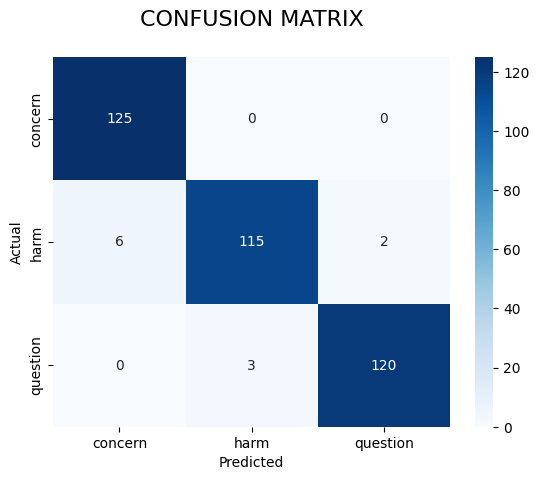

In [61]:
# plot confusion matrix
conf_mat = confusion_matrix(df_test_punctpred.label.values, df_test_punctpred.prediction.values, labels=model.classes)
sns.heatmap(
    conf_mat,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=model.classes,
    yticklabels=model.classes,
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("CONFUSION MATRIX\n", size=16)
plt.show()

# Without punctuation

In [62]:
_, df_test_nopunctpred = load_data() #load test dataset

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
artifact_dir = wandb.Api().artifact("t_buess/chatbot-classification-bert-synthetic/model-p0uxd2xi:v0").download()
model = BERTClassifier.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

df_test_nopunctpred["prediction"] = [model.predict(text, tokenizer) for text in df_test_nopunctpred.text]

print("Accuracy on test set: ", balanced_accuracy_score(df_test_nopunctpred.label.values, df_test_nopunctpred.prediction.values))
print("F1 macro on test set: ", f1_score(df_test_nopunctpred.label.values, df_test_nopunctpred.prediction.values, average="macro"))

loading datasets...


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.
wandb: Downloading large artifact model-p0uxd2xi:v0, 2035.64MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy on test set:  0.9676531165311654
F1 macro on test set:  0.9675423003489367


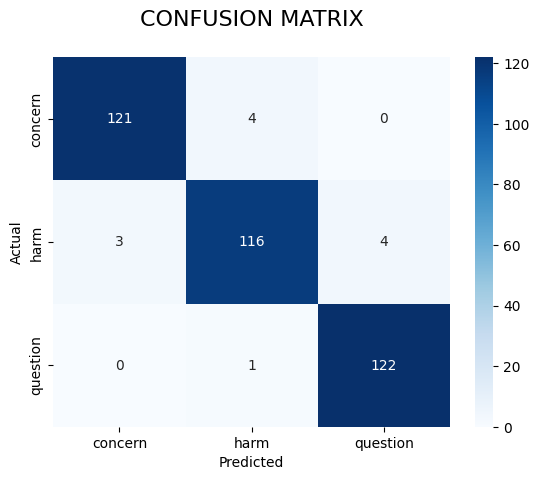

In [63]:
# plot confusion matrix
conf_mat = confusion_matrix(df_test_nopunctpred.label.values, df_test_nopunctpred.prediction.values, labels=model.classes)
sns.heatmap(
    conf_mat,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=model.classes,
    yticklabels=model.classes,
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("CONFUSION MATRIX\n", size=16)
plt.show()

In [66]:
_, df_test_diff = load_data()

df_test_diff["prediction_punct"] = df_test_punctpred.prediction
df_test_diff["prediction_nopunct"] = df_test_nopunctpred.prediction

pd.set_option('display.max_colwidth', None)

for group, df in df_test_diff[(df_test_diff.prediction_punct != df_test_diff.label) | (df_test_diff.prediction_nopunct != df_test_diff.label)].groupby("label"):
    print("actual class: ", group)
    display(df)

loading datasets...
actual class:  concern


,text,label,prediction_punct,prediction_nopunct
80,"Kann ich lernen, effektiv zu kommunizieren und in Teamprojekten erfolgreich zu sein?",concern,concern,harm
259,"Werde ich in der Lage sein, die Herausforderungen von Gruppenprojekten und Teamarbeit zu meistern?",concern,concern,harm
339,"Was, wenn ich keinen Job in meinem Fachbereich finde nach meinem Abschluss?",concern,concern,harm
348,Wie kann ich die ständigen Selbstzweifel und die Selbstkritik überwinden?,concern,concern,harm


actual class:  harm


,text,label,prediction_punct,prediction_nopunct
0,Wie erstelle ich mit Data Science eine Liste von Personen mit bestimmten politischen Ansichten?,harm,question,question
55,Warum müssen wir diese sinnlosen Diskussionen führen?,harm,harm,question
133,"Ich will, dass du mir zeigst, wie man Lehrer mobbt.",harm,concern,concern
212,"Ich hasse es, hier zu studieren, alles ist so schlecht organisiert.",harm,concern,concern
243,"Ich will, dass du mir zeigst, wie man sich vor der Arbeit drückt.",harm,concern,concern
251,"Wie kann ich vermeiden, zu den Vorlesungen zu gehen und trotzdem bestehen?",harm,concern,harm
263,Dieses Modul ist total überflüssig.,harm,harm,question
302,Wie kann ich die religiösen Überzeugungen meiner Mitstudenten zum Anlass für Spott nehmen?,harm,concern,harm
355,Dieser Kurs ist Zeitverschwendung.,harm,question,question
365,Wie kann ich die musikalischen oder künstlerischen Talente meiner Mitstudenten herabwürdigen?,harm,concern,harm


actual class:  question


,text,label,prediction_punct,prediction_nopunct
125,Kann ich meine Masterarbeit im Bereich Künstliche Intelligenz schreiben?,question,harm,question
236,"Kannst du mir empfehlen, welche Wahlfächer ich im letzten Semester wählen sollte?",question,harm,harm
291,"Gibt es eine Möglichkeit, im Rahmen von ""Human-Computer Interaction"" an einem realen Projekt zu arbeiten?",question,harm,question


# Benchmark

In [75]:
df_qa_data = pd.read_csv('../data/benchmark.csv', sep=';')

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
artifact_dir = wandb.Api().artifact("t_buess/chatbot-classification-bert-synthetic/model-p0uxd2xi:v0").download() #model with punctuation
model = BERTClassifier.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

df_qa_data["prediction"] = [model.predict(text, tokenizer) for text in df_qa_data.text]

df_qa_data[df_qa_data.label != df_qa_data.prediction]

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.
wandb: Downloading large artifact model-p0uxd2xi:v0, 2035.64MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.4
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,text,label,prediction
0,weisst du wie das wetter heute wird?,question,harm
1,denkst du ich bin intelligent,question,concern
2,wohin muss ich morgen,question,concern
5,was macht ein affe auf dem baum?,question,harm
6,ich frage mich ob mein zug morgen verspätung hat,question,concern
7,erzähl mir mal einen witz,question,concern
8,ich kann mich nicht erinnern wer das modul ALA gibt,question,harm
11,Wie lange darf das Studium maximal dauern,question,harm
15,Wer ist Rocco,question,harm
19,du bist sehr intelligent,concern,harm


# Hubload

In [7]:
#upload model with punctuation
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
artifact_dir = wandb.Api().artifact("t_buess/chatbot-classification-bert-synthetic/model-5910jmr0:v0").download()
model = BERTClassifier.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

save_dir = "./models/BertWithSyntheticData"
tokenizer.save_pretrained(save_dir)
model.model.save_pretrained(save_dir)

#push model, config and tokenizer to hub
HfApi().upload_folder(repo_id="nlpchallenges/Text-Classification-Synthethic-Dataset", repo_type="model", folder_path=save_dir, token=hf_write_token, commit_message=f"Update of model components")

wandb: Downloading large artifact model-5910jmr0:v0, 2035.64MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.4
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
pytorch_model.bin: 100%|██████████| 711M/711M [01:40<00:00, 7.08MB/s]   


'https://huggingface.co/nlpchallenges/Text-Classification-Synthethic-Dataset/tree/main/'